In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product
from datetime import datetime
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import ScalarFormatter, NullFormatter

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from scipy import stats
import gym

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

def pairedCohensD(x,y):
    """ Calculate the paired cohens d for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    return (np.mean(x-y) / np.std(x-y,ddof=1))

def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''

In [2]:
# Define File Exceptions
file_exceptions = []

# Define Non-functional Arenas (arenas that had leaks or were otherwise unusable)
arena_exceptions = [4,5,6,7,8,9,10,11,12,13,14,15]

In [3]:
all_data_unfiltered = []

data_directory = '../../16FlYMaze/HALvMHO_learning_4y/data/4-13 hrs/'

files = list(filter(lambda v: np.all([i not in v for i in file_exceptions]) and os.path.isdir(data_directory+v),os.listdir(data_directory)))
arenas = list(filter(lambda v: np.all([i != v for i in arena_exceptions]),range(16)))

for i,folder in tqdm(product(arenas,files),total=len(arenas)*len(files)):
    try:
        with open(data_directory+f"{folder}/processed_data/fly_{i}.ydata", "r") as f:
            data = json.load(f)
            for d in data.keys():
                data[d] = np.array(data[d])
        with open(data_directory+f"{folder}/fly_{i}.yexperiment", "r") as f:
            experiment = json.load(f)
            data["fly_experiment"] = experiment["fly_experiment"] + "_4_13"
            data["arena"] = i
            data["folder"] = folder
        with open(data_directory+f"{folder}/config.yarena", "r") as f:
            config = json.load(f)
            data["odor_1"] = config["odor_1"]
            data["odor_2"] = config["odor_2"]
        data["starvation"] = '4-13 hrs'
        all_data_unfiltered.append(data)
    except Exception as e:
        print(f"Failed to load data for fly {i} in folder {folder}. Error: {e}")

data_directory = '../../16FlYMaze/HALvMHO_learning_4y/data/28-37 hrs/'

files = list(filter(lambda v: np.all([i not in v for i in file_exceptions]) and os.path.isdir(data_directory+v),os.listdir(data_directory)))
arenas = list(filter(lambda v: np.all([i != v for i in arena_exceptions]),range(16)))

for i,folder in tqdm(product(arenas,files),total=len(arenas)*len(files)):
    try:
        with open(data_directory+f"{folder}/processed_data/fly_{i}.ydata", "r") as f:
            data = json.load(f)
            for d in data.keys():
                data[d] = np.array(data[d])
        with open(data_directory+f"{folder}/fly_{i}.yexperiment", "r") as f:
            experiment = json.load(f)
            data["fly_experiment"] = experiment["fly_experiment"] + "_28_37"
            data["arena"] = i
            data["folder"] = folder
        with open(data_directory+f"{folder}/config.yarena", "r") as f:
            config = json.load(f)
            data["odor_1"] = config["odor_1"]
            data["odor_2"] = config["odor_2"]
        data["starvation"] = '28-37 hrs'
        all_data_unfiltered.append(data)
    except Exception as e:
        print(f"Failed to load data for fly {i} in folder {folder}. Error: {e}")

data_directory = '../../16FlYMaze/HALvMHO_learning_4y/data/51-64 hrs/'

files = list(filter(lambda v: np.all([i not in v for i in file_exceptions]) and os.path.isdir(data_directory+v),os.listdir(data_directory)))
arenas = list(filter(lambda v: np.all([i != v for i in arena_exceptions]),range(16)))

for i,folder in tqdm(product(arenas,files),total=len(arenas)*len(files)):
    try:
        with open(data_directory+f"{folder}/processed_data/fly_{i}.ydata", "r") as f:
            data = json.load(f)
            for d in data.keys():
                data[d] = np.array(data[d])
        with open(data_directory+f"{folder}/fly_{i}.yexperiment", "r") as f:
            experiment = json.load(f)
            data["fly_experiment"] = experiment["fly_experiment"] + "_51_64"
            data["arena"] = i
            data["folder"] = folder
        with open(data_directory+f"{folder}/config.yarena", "r") as f:
            config = json.load(f)
            data["odor_1"] = config["odor_1"]
            data["odor_2"] = config["odor_2"]
        data["starvation"] = '51-64 hrs'
        all_data_unfiltered.append(data)
    except Exception as e:
        print(f"Failed to load data for fly {i} in folder {folder}. Error: {e}")

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Failed to load data for fly 1 in folder HALMHO_EXP_12_2022-09-01_12-21. Error: [Errno 2] No such file or directory: '../../16FlYMaze/HALvMHO_learning_4y/data/51-64 hrs/HALMHO_EXP_12_2022-09-01_12-21/processed_data/fly_1.ydata'


In [4]:
# make a copy of the data
all_data = all_data_unfiltered.copy()
# filter data to only include flies that have completed at least 160 trials
all_data = list(filter(lambda v: v["trial_count"] >= 100,all_data))
# remove experiments with 0-250 in the name
all_data = list(filter(lambda v: "0-250" not in v["fly_experiment"],all_data))

# print all experiments
exps, invs, counts = np.unique([d["fly_experiment"] for d in all_data],return_counts=True,return_inverse=True)
for i in range(len(exps)):
    print(f"{exps[i]}: {counts[i]} flies")
exp_to_idx = {exps[i]:i for i in range(len(exps))}
idx_to_exp = {i:exps[i] for i in range(len(exps))}

# assign names to experiments
exp_names = [
    'HAL->MHO 28-37hrs',
    'HAL->MHO 4-13hrs',
    'HAL->MHO 51-64hrs',
    'MHO->HAL 28-37hrs',
    'MHO->HAL 4-13hrs',
    'MHO->HAL 51-64hrs',
    ]

switch45_1-000_5_250-500.csv_28_37: 10 flies
switch45_1-000_5_250-500.csv_4_13: 13 flies
switch45_1-000_5_250-500.csv_51_64: 10 flies
switch45_1-000_5_250-500_reciprocal.csv_28_37: 9 flies
switch45_1-000_5_250-500_reciprocal.csv_4_13: 14 flies
switch45_1-000_5_250-500_reciprocal.csv_51_64: 9 flies


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


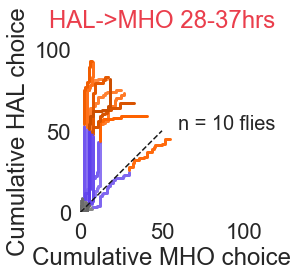

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


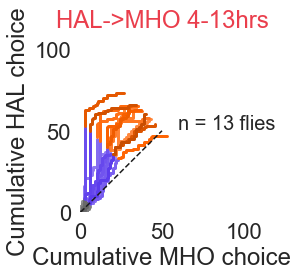

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


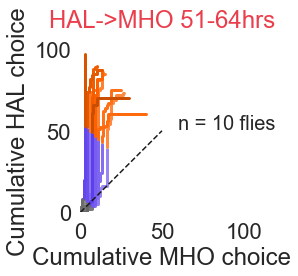

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


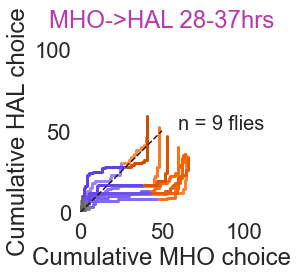

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


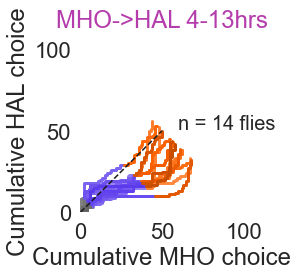

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


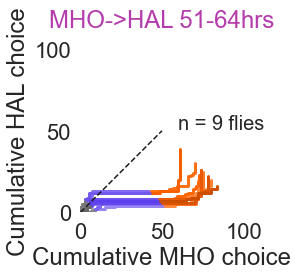

In [5]:
# plot all flies for each experiment
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # randomize order of flies
    np.random.shuffle(data)

    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(3,3))
    for i in range(len(data)):
        odor1_choice = np.cumsum(1-(data[i]['chosen_odor']-1))
        odor2_choice = np.cumsum(data[i]['chosen_odor']-1)

        exp = data[i]["fly_experiment"]
        scaler = 1 + (i/len(data) - 0.5)*0.5
        cval=0.25
        ax.plot(odor1_choice[:10], odor2_choice[:10], '-', color = change_lightness((0.5,0.5,0.5,1),scaler), alpha=1, linewidth=3)
        ax.plot(odor1_choice[10:55], odor2_choice[10:55], '-', color = change_lightness(cmap(cval),scaler), alpha=1, linewidth=3)
        ax.plot(odor1_choice[55:100], odor2_choice[55:100], '-', color = change_lightness(cmap(1-cval),scaler), alpha=1, linewidth=3)
        
    # add a text box with the number of flies
    textstr = f"n = {len(data)} flies"
    ax.text(60, 60, textstr, fontsize=20, verticalalignment='top')
    
    plt.box(False)
    ax.plot([0,50],[0,50], 'k--')
    ax.set_xlabel("Cumulative MHO choice")
    ax.set_ylabel("Cumulative HAL choice")
    limits = np.max([ax.get_xlim(),ax.get_ylim()])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
    ax.set_title(exp_name, color = cmap(0.4) if 'MHO->HAL' in exp_name else cmap(0.6), y=1.1)
    ax.set_aspect('equal')
    alt_exp_name = exp_name.replace(' ','_').replace('->','_').replace('(','').replace(')','')
    plt.savefig(f"figures/Cumulative_Choice_{alt_exp_name}.pdf",bbox_inches='tight')
    
    plt.show()

In [6]:
# plot all flies for each fly

# define logit function
def logit(x):
    x = (x+1)/2
    x = np.clip(x,1/100,1-(1/100))
    return np.log(x/(1-x))

dfs = []
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]

    folders = [d["folder"] for d in data]
    arenas = [d["arena"] for d in data]
    def get_CI(choices):
        choices = 2*(choices-1.5)
        return np.mean(choices)

    naive_CIs = np.array([get_CI(d['chosen_odor'][:10]) for d in data])
    trained_CIs = np.array([get_CI(d['chosen_odor'][10:55]) for d in data])
    reversal_CIs = np.array([get_CI(d['chosen_odor'][55:]) for d in data])
    if 'HAL->MHO' in exp_name:
        df = pd.DataFrame(
            {
            'Naive':naive_CIs,
            'Training':trained_CIs,
            'Reversal':reversal_CIs,
            'Experiment':'HAL->MHO',
            'Starvation':exp_name.split(' ')[-1],
            'MHO LI':logit(trained_CIs)-logit(reversal_CIs),
            'HAL LI':logit(trained_CIs)-logit(naive_CIs)
            }
        )
    else:
        df = pd.DataFrame(
            {
            'Naive':naive_CIs,
            'Training':trained_CIs,
            'Reversal':reversal_CIs,
            'Experiment':'MHO->HAL',
            'Starvation':exp_name.split(' ')[-1],
            'MHO LI':logit(naive_CIs)-logit(trained_CIs),
            'HAL LI':logit(reversal_CIs)-logit(trained_CIs)
            }
        )
    dfs.append(df)

df = pd.concat(dfs) 
df = pd.melt(df, id_vars=['Experiment','Starvation'], value_vars=['Naive','Training','Reversal'], var_name='Condition', value_name='Choice Index')

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Naive 4-13hrs t-test: t = 3.50, p = 0.00
Naive 28-37hrs t-test: t = 3.49, p = 0.00
Naive 51-64hrs t-test: t = -0.50, p = 0.62


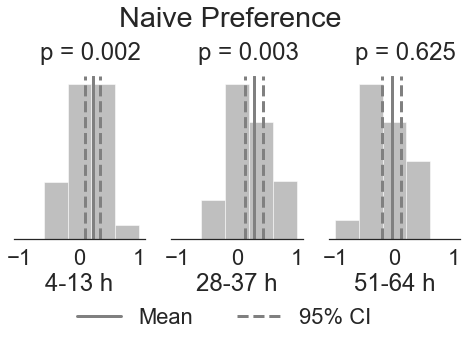

In [7]:
# plot a histogram of naive choice indices
sns.set(font_scale=2,style='white')
fig, ax = plt.subplots(1,3,figsize=(8,3))
for n,starvation in enumerate(['4-13hrs','28-37hrs','51-64hrs']):
    df_naive = df[np.logical_and(df['Condition']=='Naive',df['Starvation']==starvation)]
    ax[n].hist(df_naive['Choice Index'],bins=np.linspace(-1,1,6),color='gray',alpha=0.5)
    # plot mean and 95% CI (bootstrap)
    n_boot = 1000
    boot_means = np.zeros(n_boot)
    for i in range(n_boot):
        boot_means[i] = np.mean(np.random.choice(df_naive['Choice Index'],len(df_naive['Choice Index'])))
    ax[n].axvline(np.mean(boot_means),color='gray',linewidth=3, label='Mean')
    ax[n].axvline(np.percentile(boot_means,2.5),color='gray',linewidth=3,linestyle='--', label='95% CI')
    ax[n].axvline(np.percentile(boot_means,97.5),color='gray',linewidth=3,linestyle='--')
    # calculate one-sample t-test
    t,p = stats.ttest_1samp(df_naive['Choice Index'],0)
    print(f"Naive {starvation} t-test: t = {t:.2f}, p = {p:.2f}")
    if p < 0.001:
        pstr = 'p < 0.001'
    else:
        pstr = f'p = {p:.3f}'
    ax[n].text(0.2,1.1,pstr,transform=ax[n].transAxes)
    ax[n].set_xlabel(starvation[:-3]+' h')
    ax[n].set_xticks([-1,0,1])
    ax[n].set_ylabel("")
    ax[n].set_yticks([])
    for spine in ax[n].spines.values():
        spine.set_visible(False)
    ax[n].spines['bottom'].set_visible(True)
plt.suptitle("Naive Preference",y=1.2)
plt.legend(frameon=False,bbox_to_anchor=(-0.8,-.6),loc='lower center',borderaxespad=0,ncol=2)
plt.savefig("figures/HAL_MHO_Naive_Preference.pdf",bbox_inches='tight')
plt.show()


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calcu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MHO->HAL_Training vs. MHO->HAL_Reversal: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
MHO->HAL_Naive vs. MHO->HAL_Training: Wilcoxon test (paired samples), P_val:2.977e-03 Stat=3.000e+00
HAL->MHO_Naive vs. HAL->MHO_Training: Wilcoxon test (paired samples), P_val:1.465e-01 Stat=2.400e+01
HAL->MHO_Training vs. HAL->MHO_Reversal: Wilcoxon test (paired samples), P_val:2.441e-04 Stat=0.000e+00
MHO->HAL_Naive vs. MHO->HAL_Reversal: Wilcoxon test (paired samples), P_val:3.575e-01 Stat=3.700e+01
HAL->MHO_Naive vs. HAL->MHO_Reversal: Wilcoxon test (paired samples), P_val:1.343e-02 Stat=1.100e+01


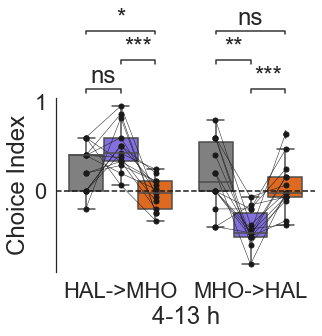

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MHO->HAL_Training vs. MHO->HAL_Reversal: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=0.000e+00
MHO->HAL_Naive vs. MHO->HAL_Training: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=0.000e+00
HAL->MHO_Naive vs. HAL->MHO_Training: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
HAL->MHO_Training vs. HAL->MHO_Reversal: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MHO->HAL_Naive vs. MHO->HAL_Reversal: Wilcoxon test (paired samples), P_val:5.703e-01 Stat=1.700e+01
HAL->MHO_Naive vs. HAL->MHO_Reversal: Wilcoxon test (paired samples), P_val:6.953e-01 Stat=2.300e+01


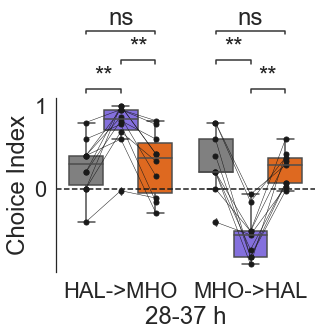

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calcu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MHO->HAL_Training vs. MHO->HAL_Reversal: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=0.000e+00
MHO->HAL_Naive vs. MHO->HAL_Training: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=1.000e+00
HAL->MHO_Naive vs. HAL->MHO_Training: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
HAL->MHO_Training vs. HAL->MHO_Reversal: Wilcoxon test (paired samples), P_val:3.711e-02 Stat=6.500e+00
MHO->HAL_Naive vs. MHO->HAL_Reversal: Wilcoxon test (paired samples), P_val:5.281e-01 Stat=1.350e+01
HAL->MHO_Naive vs. HAL->MHO_Reversal: Wilcoxon test (paired samples), P_val:4.883e-02 Stat=8.000e+00


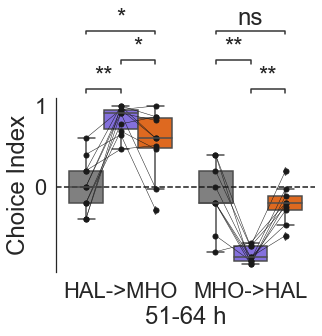

In [8]:
# make a paired boxplot of the data

df = pd.concat(dfs)
df = pd.melt(df, id_vars=['Experiment','Starvation'], value_vars=['Naive','Training','Reversal'], var_name='Condition', value_name='Choice Index')


for starvation in ['4-13hrs','28-37hrs','51-64hrs']:
    df = pd.concat(dfs)
    df = pd.melt(df, id_vars=['Experiment','Starvation'], value_vars=['Naive','Training','Reversal'], var_name='Condition', value_name='Choice Index') 
    df = df[df['Starvation']==starvation]

    sns.set(font_scale=2,style='white')
    fig, ax = plt.subplots(figsize=(5,6))

    sns.boxplot(x='Experiment',y='Choice Index',hue='Condition',data=df,ax=ax,palette=[(0.5,0.5,0.5,1),cmap(0.25),cmap(0.75)])
    plt.legend([],[], frameon=False)
    ax.plot([-0.27,0,0.27],[df[np.logical_and(df['Experiment']=='HAL->MHO',df['Condition']=='Naive')]['Choice Index'].values,
                        df[np.logical_and(df['Experiment']=='HAL->MHO',df['Condition']=='Training')]['Choice Index'].values,    
                        df[np.logical_and(df['Experiment']=='HAL->MHO',df['Condition']=='Reversal')]['Choice Index'].values],'-',color='k',marker='o',markersize=5,linewidth=0.5)
    ax.plot([0.73,1,1.27],[df[np.logical_and(df['Experiment']=='MHO->HAL',df['Condition']=='Naive')]['Choice Index'].values,
                        df[np.logical_and(df['Experiment']=='MHO->HAL',df['Condition']=='Training')]['Choice Index'].values,
                        df[np.logical_and(df['Experiment']=='MHO->HAL',df['Condition']=='Reversal')]['Choice Index'].values],'-',color='k',marker='o',markersize=5,linewidth=0.5)
    
    ax.set_xlim([-0.5,1.5])
    ax.set_ylabel('Choice Index')
    ax.set_yticks([0,1])
    ax.set_xlabel(starvation[:-3]+' h')
    ax.set_xticklabels(['HAL->MHO','MHO->HAL'])

    # turn off all the spines except the left
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['left'].set_visible(True)

    # add significance
    pairs = [[('MHO->HAL','Naive'),('MHO->HAL','Training')],
                [('MHO->HAL','Naive'),('MHO->HAL','Reversal')],
                [('MHO->HAL','Training'),('MHO->HAL','Reversal')],
                [('HAL->MHO','Naive'),('HAL->MHO','Training')],
                [('HAL->MHO','Naive'),('HAL->MHO','Reversal')],
                [('HAL->MHO','Training'),('HAL->MHO','Reversal')]]

    annotator = Annotator(ax, pairs, data=df, x='Experiment', y='Choice Index', hue='Condition')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    # draw horizontal lines at 0
    ax.axhline(0, ls='--', color='k')

    plt.tight_layout()
    plt.savefig(f"figures/HALvMHO_Choice_Index_{starvation}.pdf",bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HAL LI_HAL->MHO vs. HAL LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:3.198e-01 U_stat=7.000e+01
MHO LI_HAL->MHO vs. MHO LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:8.651e-01 U_stat=8.700e+01
MHO LI_MHO->HAL vs. HAL LI_HAL->MHO: Mann-Whitney-Wilcoxon test two-sided, P_val:1.262e-01 U_stat=1.230e+02
MHO LI_HAL->MHO vs. HAL LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:7.159e-01 U_stat=9.900e+01


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HAL LI_HAL->MHO vs. HAL LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:7.133e-01 U_stat=4.000e+01
MHO LI_HAL->MHO vs. MHO LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:4.377e-01 U_stat=3.500e+01
MHO LI_MHO->HAL vs. HAL LI_HAL->MHO: Mann-Whitney-Wilcoxon test two-sided, P_val:6.534e-01 U_stat=5.100e+01
MHO LI_HAL->MHO vs. HAL LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:7.132e-01 U_stat=4.000e+01


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HAL LI_HAL->MHO vs. HAL LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:3.074e-01 U_stat=5.800e+01
MHO LI_HAL->MHO vs. MHO LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.113e-01 U_stat=2.500e+01
MHO LI_MHO->HAL vs. HAL LI_HAL->MHO: Mann-Whitney-Wilcoxon test two-sided, P_val:5.956e-01 U_stat=3.800e+01
MHO LI_HAL->MHO vs. HAL LI_MHO->HAL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.530e-01 U_stat=2.700e+01


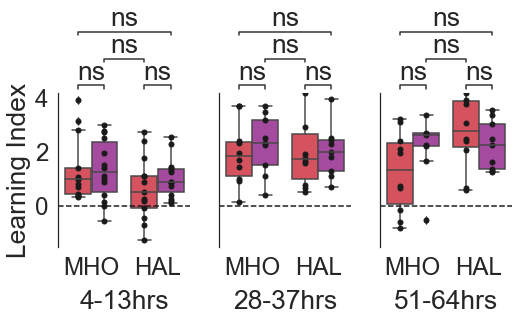

In [9]:
# make a paired boxplot of the data
sns.set(font_scale=2.2,style='white')
fig, axs = plt.subplots(1,3,figsize=(8,6),sharey=True,sharex=True)

df = pd.concat(dfs)

for i,starvation in enumerate(['4-13hrs','28-37hrs','51-64hrs']):
    ax = axs[i]
    df = pd.concat(dfs)
    df = pd.melt(df, id_vars=['Experiment','Starvation'], value_vars=['MHO LI','HAL LI'], var_name='Condition', value_name='Learning Index')
    df = df[df['Starvation']==starvation]

    sns.boxplot(x='Condition',y='Learning Index',hue='Experiment',data=df,ax=ax,palette=[cmap(0.6),cmap(0.4)])
    ax.plot(-0.2*np.ones_like(df[np.logical_and(df['Experiment']=='HAL->MHO',df['Condition']=='MHO LI')]['Learning Index'].values),
                df[np.logical_and(df['Experiment']=='HAL->MHO',df['Condition']=='MHO LI')]['Learning Index'].values,'o',color='k',markersize=5)
    ax.plot(0.2*np.ones_like(df[np.logical_and(df['Experiment']=='MHO->HAL',df['Condition']=='MHO LI')]['Learning Index'].values),
                df[np.logical_and(df['Experiment']=='MHO->HAL',df['Condition']=='MHO LI')]['Learning Index'].values,'o',color='k',markersize=5)
    
    ax.plot(0.8*np.ones_like(df[np.logical_and(df['Experiment']=='HAL->MHO',df['Condition']=='HAL LI')]['Learning Index'].values),
                df[np.logical_and(df['Experiment']=='HAL->MHO',df['Condition']=='HAL LI')]['Learning Index'].values,'o',color='k',markersize=5)
    ax.plot(1.2*np.ones_like(df[np.logical_and(df['Experiment']=='MHO->HAL',df['Condition']=='HAL LI')]['Learning Index'].values),
                df[np.logical_and(df['Experiment']=='MHO->HAL',df['Condition']=='HAL LI')]['Learning Index'].values,'o',color='k',markersize=5)

    # add legend at bottom
    ax.legend([],[], frameon=False)
    ax.set_xlim([-0.5,1.5])
    if i == 0:
        ax.set_ylabel('Learning Index')
    else:
        ax.set_ylabel('')
    ax.set_xlabel(starvation,labelpad=10)
    ax.set_xticklabels(['MHO','HAL'])

    # turn off all the spines except the left
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['left'].set_visible(True)

    # add significance
    pairs = [[('MHO LI','HAL->MHO'),('MHO LI','MHO->HAL')],
                [('HAL LI','HAL->MHO'),('HAL LI','MHO->HAL')],
                [('MHO LI','MHO->HAL'),('HAL LI','HAL->MHO')],
                [('MHO LI','HAL->MHO'),('HAL LI','MHO->HAL')]]

    annotator = Annotator(ax, pairs, data=df, x='Condition', y='Learning Index', hue='Experiment')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    # draw horizontal lines at 0
    ax.axhline(0, ls='--', color='k')

plt.tight_layout()
plt.savefig(f"figures/MHO-HAL_Learning_Index.pdf",bbox_inches='tight')
plt.show()


In [10]:
df = pd.concat(dfs)
df = pd.melt(df, id_vars=['Experiment','Starvation'], value_vars=['MHO LI','HAL LI'], var_name='Odor', value_name='Learning_Index')
df.columns = ['Order','Starvation','Odor','Learning_Index']

# run a ANOVA to test for differences in learning index between experiments, probabilities, and odors
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# define the model
model = anova_lm(ols('Learning_Index ~ C(Order) + C(Starvation) + C(Odor) + C(Order):C(Starvation) + C(Order):C(Odor) + C(Starvation):C(Odor) + C(Order):C(Starvation):C(Odor)', data=df).fit())

# save the results
model.to_csv('data/HAL-MHO_Learning_Index_ANOVA.csv')
model

,df,sum_sq,mean_sq,F,PR(>F)
C(Order),1.0,0.778867,0.778867,0.552306,0.458854
C(Starvation),2.0,33.943850,16.971925,12.035046,0.000018
C(Odor),1.0,0.000505,0.000505,0.000358,0.984934
C(Order):C(Starvation),2.0,0.063699,0.031850,0.022585,0.977672
C(Order):C(Odor),1.0,2.101451,2.101451,1.490171,0.224624
C(Starvation):C(Odor),2.0,8.488852,4.244426,3.009786,0.053102
C(Order):C(Starvation):C(Odor),2.0,6.355494,3.177747,2.253388,0.109545
Residual,118.0,166.404603,1.410209,NaN,NaN
